In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Dataset

Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


# set the directory based on the folder where you saved dataset
train_data_dir = '/content/drive/MyDrive/DL Resit/archive (1)/seg_train/seg_train'
test_data_dir = '/content/drive/MyDrive/DL Resit/archive (1)/seg_test/seg_test'
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_data = image_generator.flow_from_directory(batch_size=64,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(64,64),
                                                 subset="training",
                                                 class_mode='categorical')

val_data = image_generator.flow_from_directory(batch_size=64,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(64,64),
                                                 subset="validation",
                                                 class_mode='categorical')

# Added this to make model predictions
val_data_pred = image_generator.flow_from_directory(batch_size=64,
                                                 directory=train_data_dir,
                                                 shuffle=False,
                                                 target_size=(64,64),
                                                 subset="validation",
                                                 class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(test_data_dir,
                                       target_size=(64,64), batch_size=64, shuffle=False)

print(train_data.classes)
print(val_data.classes)
print(train_data.class_indices)
print(test_data.classes)
class_names = np.unique(train_data.classes)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
[0 0 0 ... 5 5 5]


# Preprocessing and EDA (Exploratory Data Analysis)


## Visualizing Sample Images

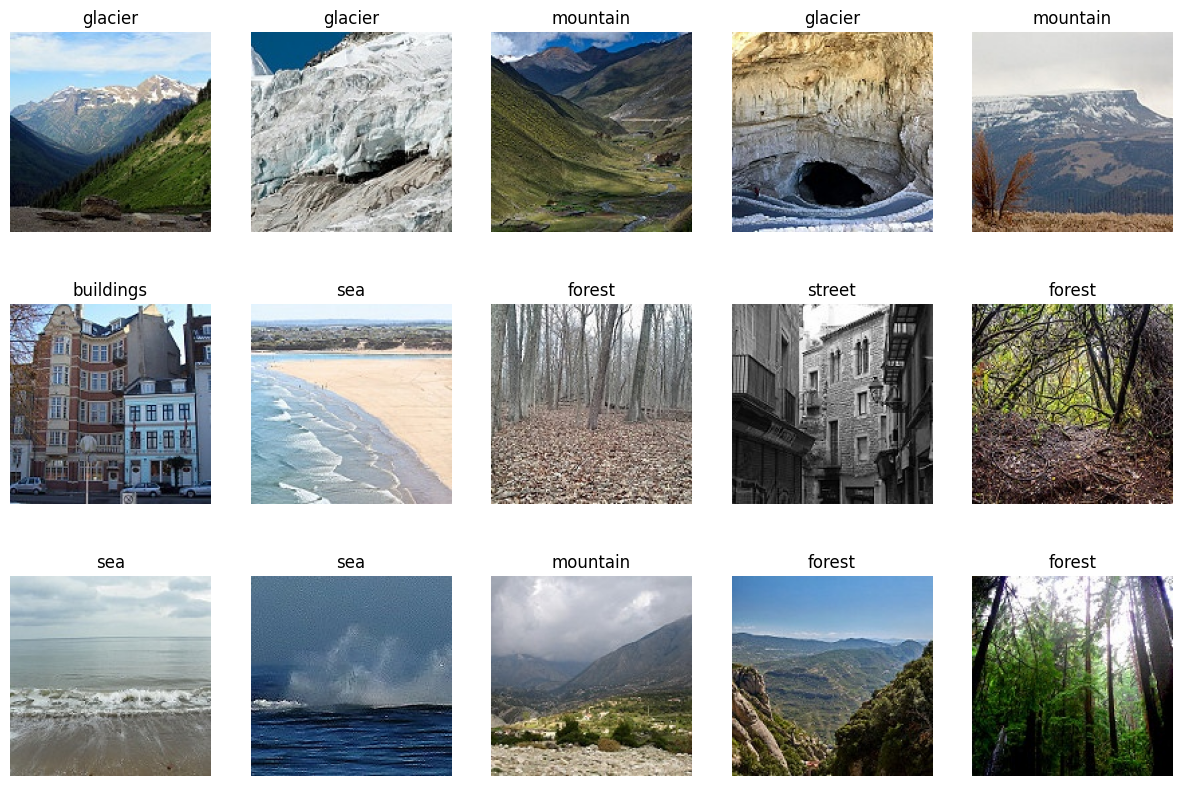

In [ ]:
from keras.preprocessing.image import load_img

filepaths = np.array(train_data.filepaths + val_data.filepaths + test_data.filepaths)
labels = np.concatenate((train_data.labels, val_data.labels, test_data.labels))

num_images = train_data.samples
random_indices = np.random.choice(num_images, size=15, replace=False)

random_15_files = filepaths[random_indices]
random_15_images = [ ]
random_15_labels = labels[random_indices]

for file in random_15_files:
  random_15_images.append(load_img(file))

random_15_labels_name = [ ]
for i in list(random_15_labels):
  for key in train_data.class_indices.keys():
    if train_data.class_indices[key] == i:
      random_15_labels_name.append(key)


import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()
for i, ax in zip(range(15), axes):
  ax.imshow(random_15_images[i])
  ax.set_title(random_15_labels_name[i])
  ax.axis('off')
plt.show()


## Visualizing Class Distribution

(array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9'), array([2628, 2745, 2957, 3037, 2784, 2883]))
['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
[2628 2745 2957 3037 2784 2883]


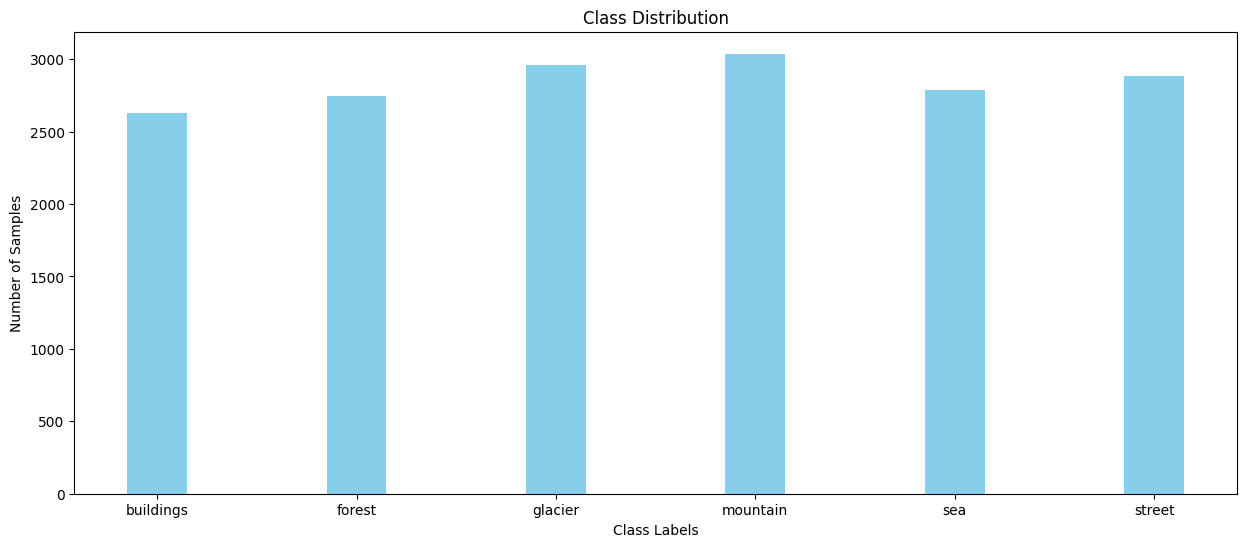

In [ ]:
# Count the occurrence of each class label
labels = np.concatenate((train_data.labels, val_data.labels, test_data.labels))
labels_name = [ ]
for i in list(labels):
  for key in train_data.class_indices.keys():
    if train_data.class_indices[key] == i:
      labels_name.append(key)

unique, counts = np.unique(labels_name, return_counts=True)
print(np.unique(labels_name, return_counts=True))
print(unique)
print(counts)


# Create bar plot
plt.figure(figsize=(15, 6))
plt.bar(unique, counts, color='skyblue',width=0.3)
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(unique)
plt.show()



# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [ ]:
def plot_history(data_list, label_list, title, ylabel):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [ ]:
## LOSS-ACC GRAPHS
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):

    # Extracting the loss and accuracy values for plotting
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting training and validation -- loss and accuracy
    plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
    plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')


In [ ]:
#Conf matrix and Classification Report:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

def confusion_matrix_and_classreport(y_true, y_pred, sets):
        # Decode the labels (only keep the one has the highest probability)
        #y_true = y_true.argmax(axis=1)
        y_pred = y_pred.argmax(axis=1)
        plt.figure(figsize=(5,5))
        # Plot the heatmap
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', xticklabels = np.unique(labels), yticklabels = np.unique(labels))
        plt.title(f'{sets} Confusion Matrix')
        plt.xlabel('Predicted labels', fontsize = 10)
        plt.ylabel('True labels', fontsize = 10)
        plt.show()
        # Print the classification report
        print("Classification Report")
        print(classification_report(y_true, y_pred))


In [ ]:
#ROC curves
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

def plot_roc_curve(y_true, y_pred, sets):

    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    y_true = enc.fit_transform(y_true.reshape(-1, 1))

    # Prepare figure
    plt.figure(figsize=(8, 5))
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    # Interpolate all roc curves at these points
    mean_tpr = np.zeros_like(fpr_grid)
    # Plot roc curve for each class
    n_classes = y_true.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
        mean_tpr += np.interp(fpr_grid, fpr, tpr)  # linear interpolation Keep adding the tpr for the macro-average calculation)

    # Average it and compute auc
    mean_tpr /= n_classes
    roc_auc = auc(fpr_grid, mean_tpr)
    plt.plot(fpr_grid, mean_tpr, label=f'Macro-average (AUC = {roc_auc:.2f})', linestyle='--' )

    # Plot micro-average roc curve
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Micro-average (AUC = {roc_auc:.2f})', linestyle='--')

    # Plot chance diagnol line
    plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Chance')

    plt.title(f'{sets} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Baseline Model

### Model

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32)

Epoch 1/20
176/176 [==============================] - 5200s 30s/step - loss: 1.1745 - categorical_accuracy: 0.5329 - val_loss: 0.9313 - val_categorical_accuracy: 0.6451
Epoch 2/20
176/176 [==============================] - 36s 205ms/step - loss: 0.8509 - categorical_accuracy: 0.6842 - val_loss: 0.7669 - val_categorical_accuracy: 0.7143
Epoch 3/20
176/176 [==============================] - 36s 206ms/step - loss: 0.7042 - categorical_accuracy: 0.7492 - val_loss: 0.6572 - val_categorical_accuracy: 0.7750
Epoch 4/20
176/176 [==============================] - 36s 207ms/step - loss: 0.5936 - categorical_accuracy: 0.7850 - val_loss: 0.6552 - val_categorical_accuracy: 0.7557
Epoch 5/20
176/176 [==============================] - 36s 203ms/step - loss: 0.5310 - categorical_accuracy: 0.8083 - val_loss: 0.5313 - val_categorical_accuracy: 0.8170
Epoch 6/20
176/176 [==============================] - 36s 205ms/step - loss: 0.4784 - categorical_accuracy: 0.8320 - val_loss: 0.5104 - val_categorical_acc

### Evaluating

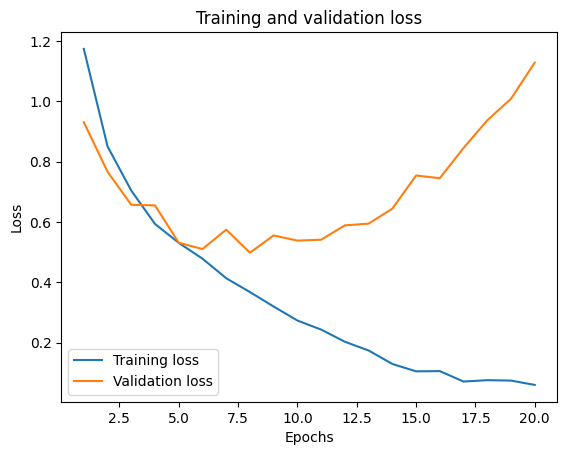

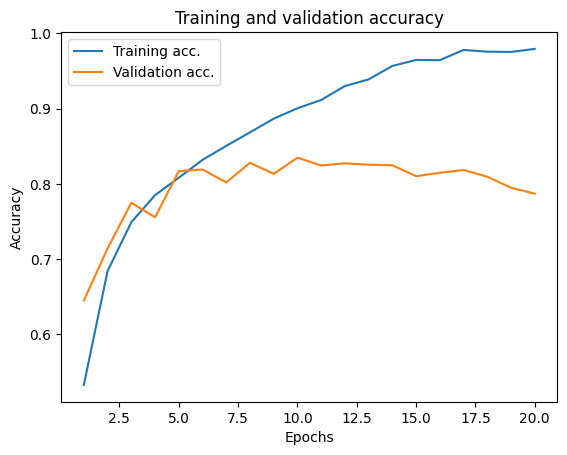

In [ ]:
plot_loss_accuracy(history)

In [ ]:
val_true = val_data_pred.labels
val_pred = model.predict(val_data_pred, verbose=0)

test_true = test_data.labels
test_pred = model.predict(test_data, verbose=0)

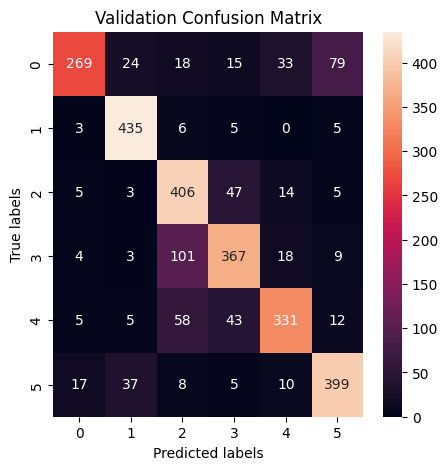

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.61      0.73       438
           1       0.86      0.96      0.91       454
           2       0.68      0.85      0.75       480
           3       0.76      0.73      0.75       502
           4       0.82      0.73      0.77       454
           5       0.78      0.84      0.81       476

    accuracy                           0.79      2804
   macro avg       0.80      0.79      0.79      2804
weighted avg       0.80      0.79      0.78      2804



In [ ]:
confusion_matrix_and_classreport(val_data_pred.labels, val_pred, "Validation")

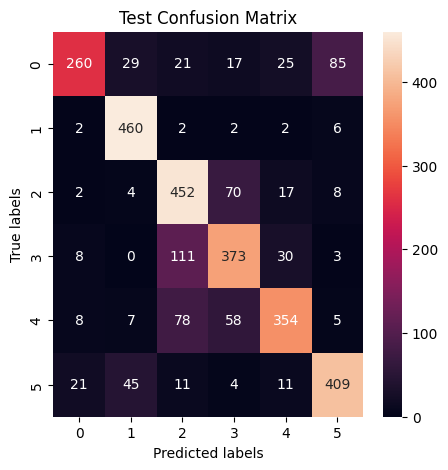

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.59      0.70       437
           1       0.84      0.97      0.90       474
           2       0.67      0.82      0.74       553
           3       0.71      0.71      0.71       525
           4       0.81      0.69      0.75       510
           5       0.79      0.82      0.80       501

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.78      0.77      0.77      3000



In [ ]:
confusion_matrix_and_classreport(test_data.labels, test_pred, "Test")

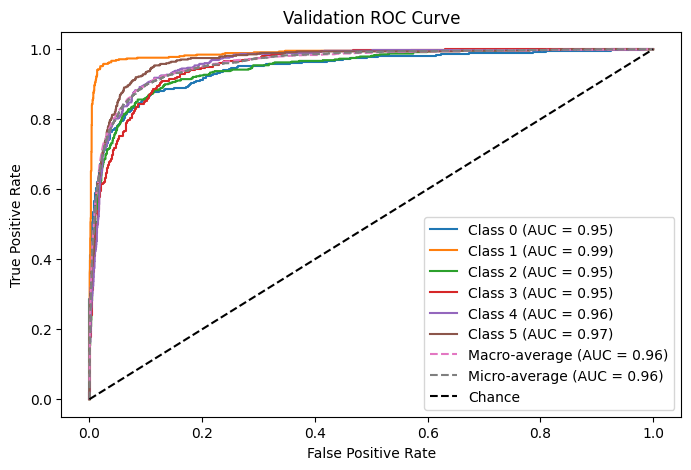

In [ ]:
plot_roc_curve(val_data_pred.labels, val_pred, "Validation")

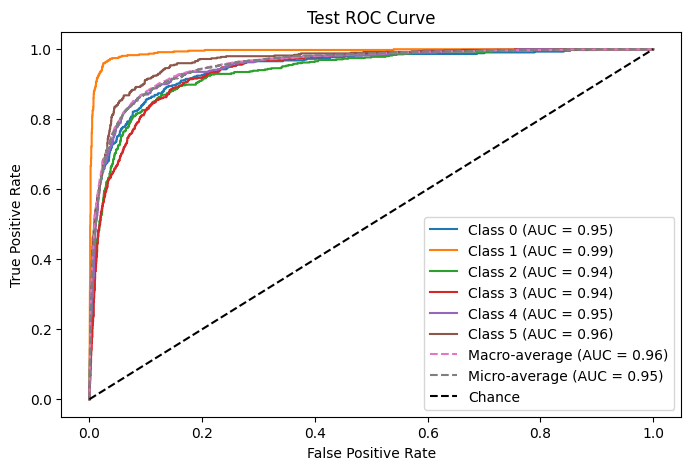

In [ ]:
plot_roc_curve(test_data.labels, test_pred, "Test")

# Enhanced Model

## Experimental model 1 -- Adding regularizer



### Model New


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 64)         

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32)

Epoch 1/20
176/176 [==============================] - 38s 203ms/step - loss: 1.2903 - categorical_accuracy: 0.5508 - val_loss: 1.0559 - val_categorical_accuracy: 0.6387
Epoch 2/20
176/176 [==============================] - 37s 208ms/step - loss: 0.9738 - categorical_accuracy: 0.6735 - val_loss: 0.8773 - val_categorical_accuracy: 0.7186
Epoch 3/20
176/176 [==============================] - 36s 204ms/step - loss: 0.8786 - categorical_accuracy: 0.7180 - val_loss: 0.8408 - val_categorical_accuracy: 0.7375
Epoch 4/20
176/176 [==============================] - 36s 206ms/step - loss: 0.8143 - categorical_accuracy: 0.7430 - val_loss: 0.7771 - val_categorical_accuracy: 0.7707
Epoch 5/20
176/176 [==============================] - 36s 203ms/step - loss: 0.7514 - categorical_accuracy: 0.7736 - val_loss: 0.7457 - val_categorical_accuracy: 0.7760
Epoch 6/20
176/176 [==============================] - 37s 208ms/step - loss: 0.7240 - categorical_accuracy: 0.7830 - val_loss: 0.7320 - val_categorical_acc

### Evaluating

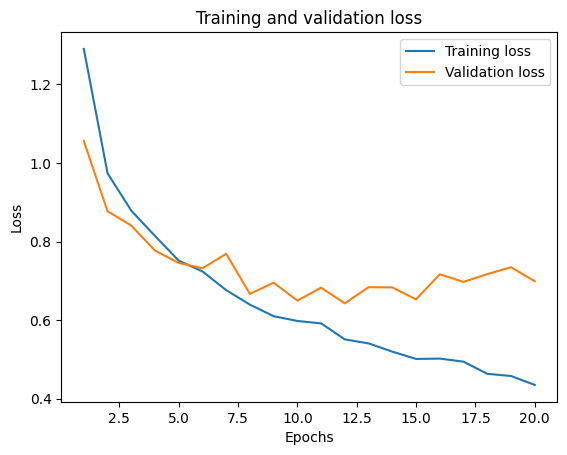

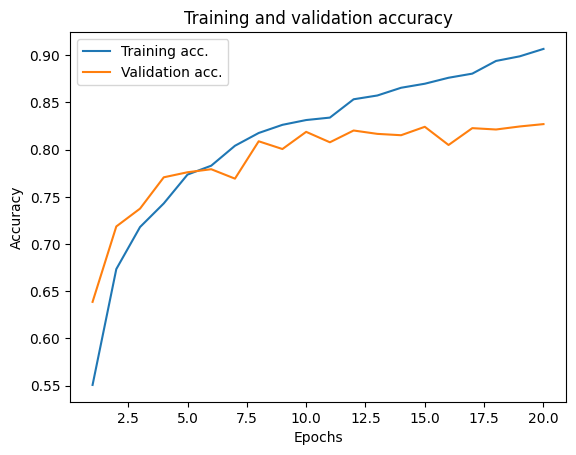

In [ ]:
plot_loss_accuracy(history)

In [ ]:
val_true = val_data_pred.labels
val_pred = model.predict(val_data_pred, verbose=0)

test_true = test_data.labels
test_pred = model.predict(test_data, verbose=0)

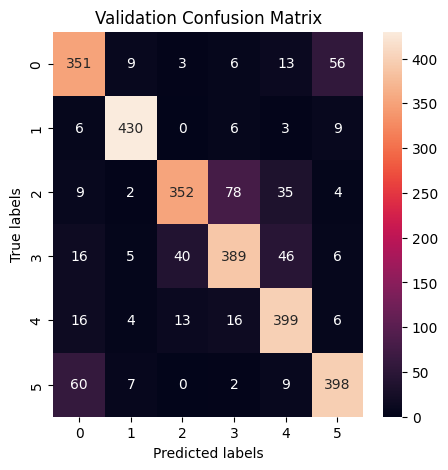

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       438
           1       0.94      0.95      0.94       454
           2       0.86      0.73      0.79       480
           3       0.78      0.77      0.78       502
           4       0.79      0.88      0.83       454
           5       0.83      0.84      0.83       476

    accuracy                           0.83      2804
   macro avg       0.83      0.83      0.83      2804
weighted avg       0.83      0.83      0.83      2804



In [ ]:
confusion_matrix_and_classreport(val_data_pred.labels, val_pred, "Validation")

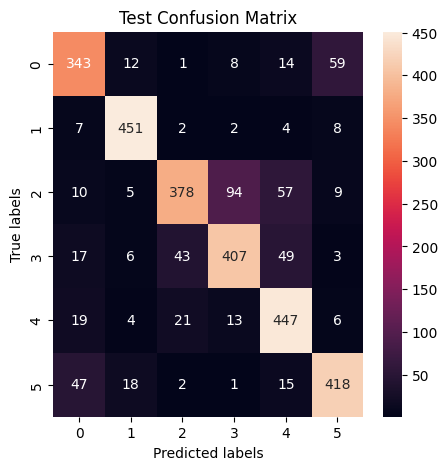

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       437
           1       0.91      0.95      0.93       474
           2       0.85      0.68      0.76       553
           3       0.78      0.78      0.78       525
           4       0.76      0.88      0.82       510
           5       0.83      0.83      0.83       501

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.81      3000
weighted avg       0.82      0.81      0.81      3000



In [ ]:
confusion_matrix_and_classreport(test_data.labels, test_pred, "Test")

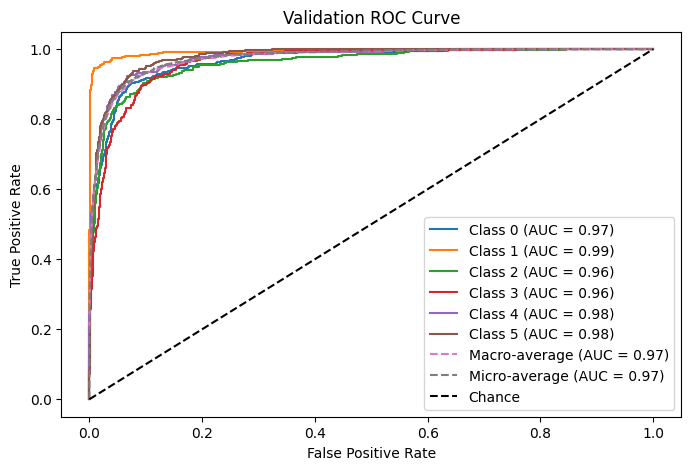

In [ ]:
plot_roc_curve(val_data_pred.labels, val_pred, "Validation")

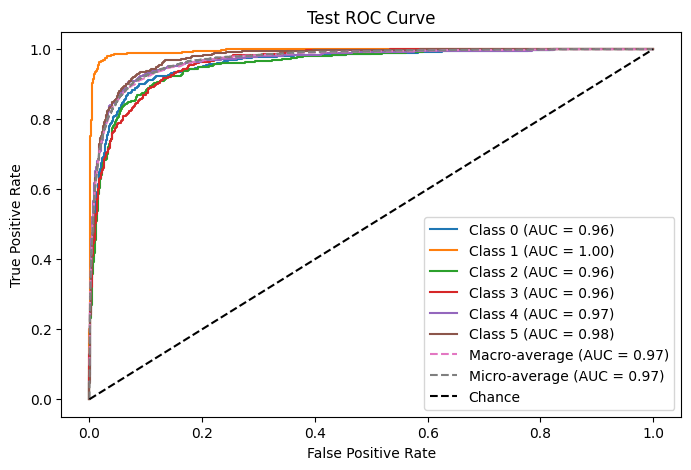

In [ ]:
plot_roc_curve(test_data.labels, test_pred, "Test")

## Experimental model 2 -- Adding dropout layer

### Model New


In [32]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)       

In [34]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32)

Epoch 1/20
176/176 [==============================] - 39s 206ms/step - loss: 1.3202 - categorical_accuracy: 0.5386 - val_loss: 1.1377 - val_categorical_accuracy: 0.6009
Epoch 2/20
176/176 [==============================] - 37s 208ms/step - loss: 0.9948 - categorical_accuracy: 0.6652 - val_loss: 0.9332 - val_categorical_accuracy: 0.7051
Epoch 3/20
176/176 [==============================] - 36s 204ms/step - loss: 0.8803 - categorical_accuracy: 0.7159 - val_loss: 0.8692 - val_categorical_accuracy: 0.7236
Epoch 4/20
176/176 [==============================] - 36s 205ms/step - loss: 0.7925 - categorical_accuracy: 0.7549 - val_loss: 0.8428 - val_categorical_accuracy: 0.7322
Epoch 5/20
176/176 [==============================] - 37s 208ms/step - loss: 0.7532 - categorical_accuracy: 0.7701 - val_loss: 0.8064 - val_categorical_accuracy: 0.7575
Epoch 6/20
176/176 [==============================] - 36s 206ms/step - loss: 0.7086 - categorical_accuracy: 0.7880 - val_loss: 0.8076 - val_categorical_acc

### Evaluating

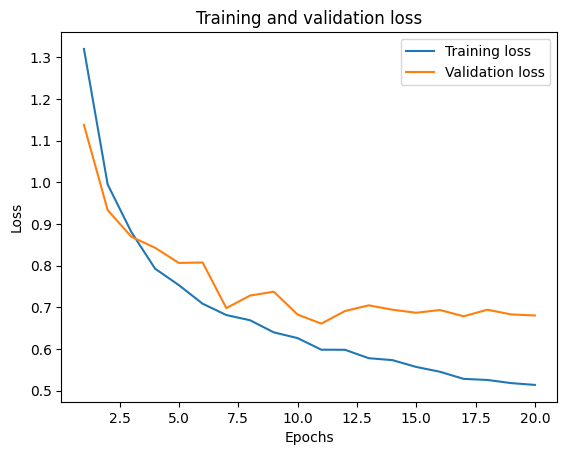

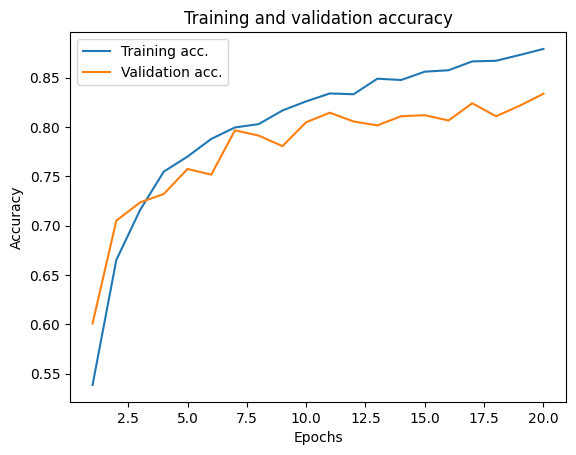

In [35]:
plot_loss_accuracy(history)

In [36]:
val_true = val_data_pred.labels
val_pred = model.predict(val_data_pred, verbose=0)

test_true = test_data.labels
test_pred = model.predict(test_data, verbose=0)

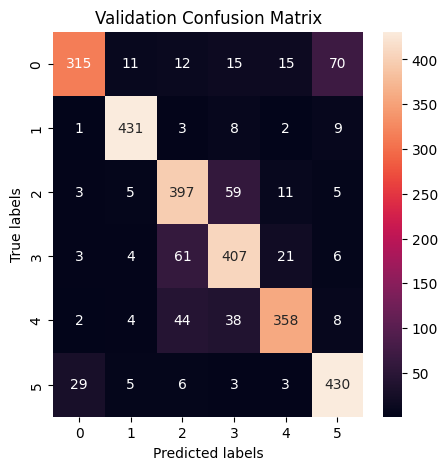

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       438
           1       0.94      0.95      0.94       454
           2       0.76      0.83      0.79       480
           3       0.77      0.81      0.79       502
           4       0.87      0.79      0.83       454
           5       0.81      0.90      0.86       476

    accuracy                           0.83      2804
   macro avg       0.84      0.83      0.83      2804
weighted avg       0.84      0.83      0.83      2804



In [37]:
confusion_matrix_and_classreport(val_data_pred.labels, val_pred, "Validation")

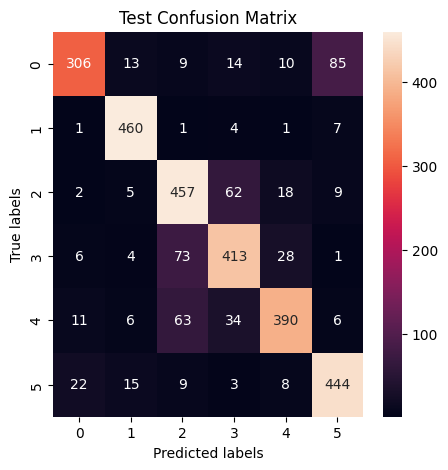

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       437
           1       0.91      0.97      0.94       474
           2       0.75      0.83      0.78       553
           3       0.78      0.79      0.78       525
           4       0.86      0.76      0.81       510
           5       0.80      0.89      0.84       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



In [38]:
confusion_matrix_and_classreport(test_data.labels, test_pred, "Test")

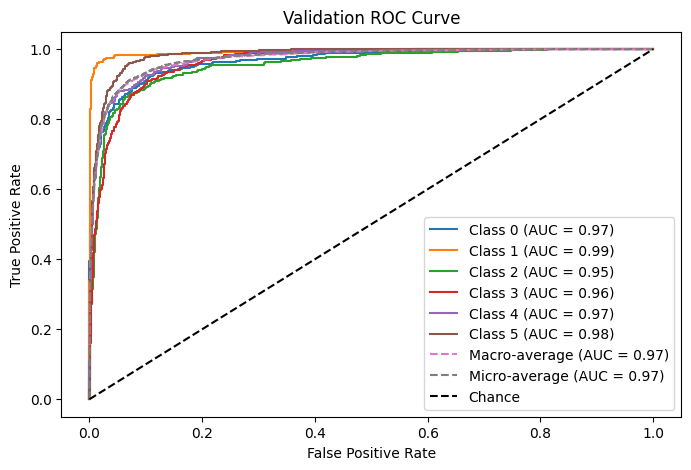

In [39]:
plot_roc_curve(val_data_pred.labels, val_pred, "Validation")

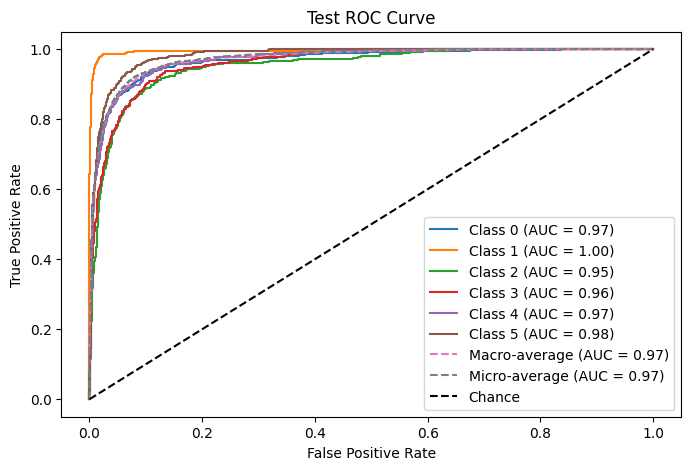

In [40]:
plot_roc_curve(test_data.labels, test_pred, "Test")

## Experimental model 3 -- Tuning the amount of filters

### Model New


In [41]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 256)      

In [43]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32)

Epoch 1/20
176/176 [==============================] - 39s 206ms/step - loss: 1.3796 - categorical_accuracy: 0.5265 - val_loss: 1.1277 - val_categorical_accuracy: 0.6073
Epoch 2/20
176/176 [==============================] - 36s 203ms/step - loss: 1.0157 - categorical_accuracy: 0.6402 - val_loss: 0.9459 - val_categorical_accuracy: 0.6783
Epoch 3/20
176/176 [==============================] - 36s 204ms/step - loss: 0.8921 - categorical_accuracy: 0.6927 - val_loss: 0.8839 - val_categorical_accuracy: 0.6915
Epoch 4/20
176/176 [==============================] - 36s 204ms/step - loss: 0.8213 - categorical_accuracy: 0.7298 - val_loss: 0.7648 - val_categorical_accuracy: 0.7657
Epoch 5/20
176/176 [==============================] - 37s 209ms/step - loss: 0.7644 - categorical_accuracy: 0.7576 - val_loss: 0.8013 - val_categorical_accuracy: 0.7546
Epoch 6/20
176/176 [==============================] - 36s 206ms/step - loss: 0.7310 - categorical_accuracy: 0.7744 - val_loss: 0.7375 - val_categorical_acc

### Evaluating

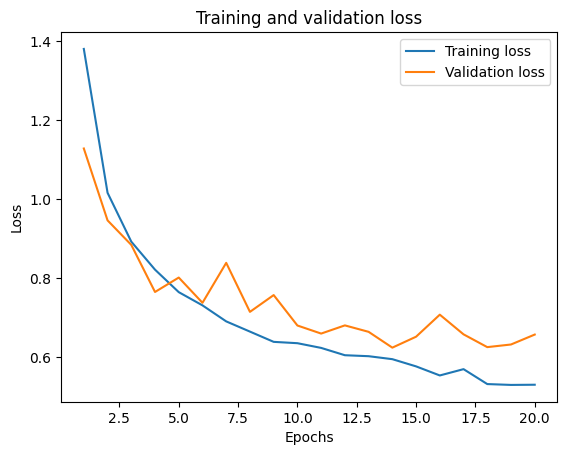

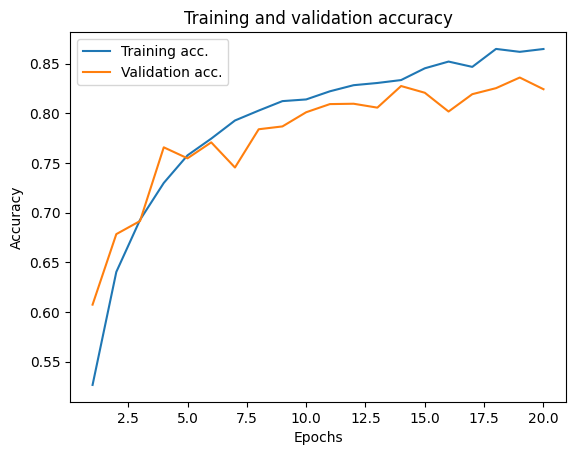

In [44]:
plot_loss_accuracy(history)

In [45]:
val_true = val_data_pred.labels
val_pred = model.predict(val_data_pred, verbose=0)

test_true = test_data.labels
test_pred = model.predict(test_data, verbose=0)

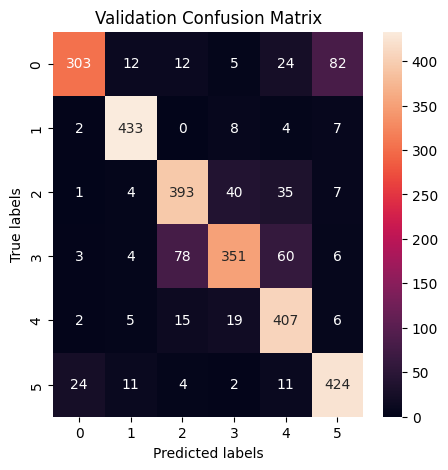

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       438
           1       0.92      0.95      0.94       454
           2       0.78      0.82      0.80       480
           3       0.83      0.70      0.76       502
           4       0.75      0.90      0.82       454
           5       0.80      0.89      0.84       476

    accuracy                           0.82      2804
   macro avg       0.83      0.83      0.82      2804
weighted avg       0.83      0.82      0.82      2804



In [46]:
confusion_matrix_and_classreport(val_data_pred.labels, val_pred, "Validation")

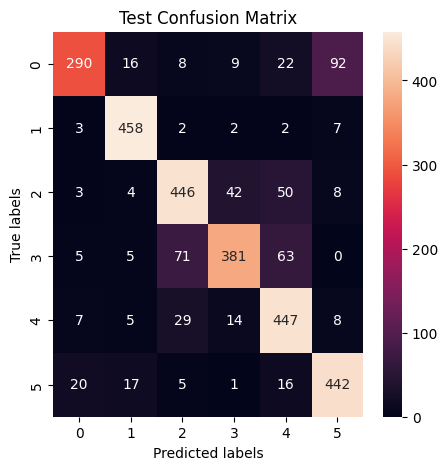

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.66      0.76       437
           1       0.91      0.97      0.94       474
           2       0.80      0.81      0.80       553
           3       0.85      0.73      0.78       525
           4       0.74      0.88      0.81       510
           5       0.79      0.88      0.84       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



In [47]:
confusion_matrix_and_classreport(test_data.labels, test_pred, "Test")

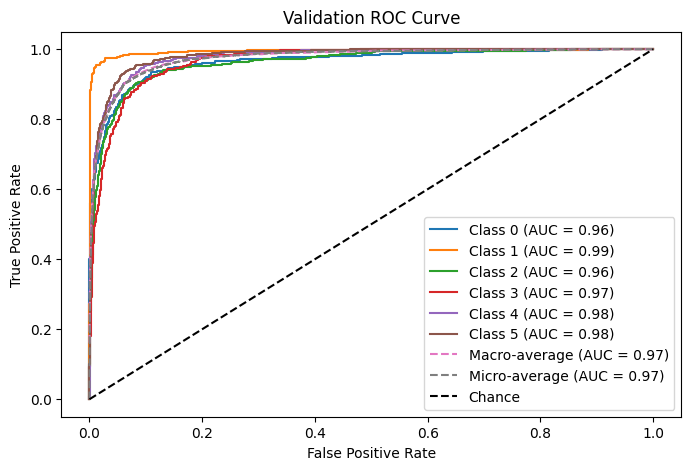

In [48]:
plot_roc_curve(val_data_pred.labels, val_pred, "Validation")

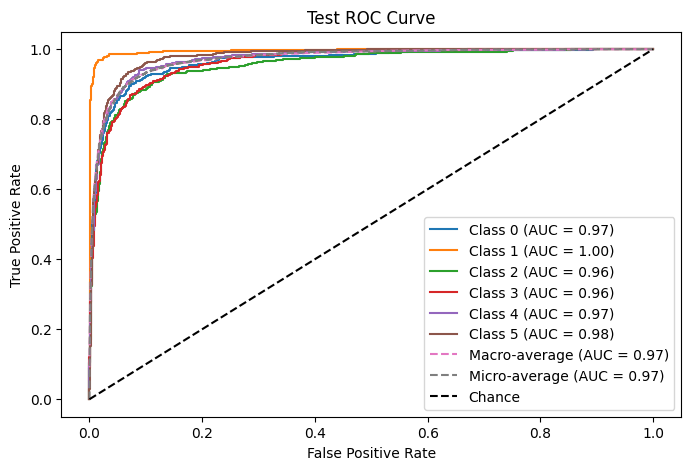

In [49]:
plot_roc_curve(test_data.labels, test_pred, "Test")

## Experimental model 4 -- Adding CNN layers

### Model New


In [50]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 256)      

In [52]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32)

Epoch 1/20
176/176 [==============================] - 38s 203ms/step - loss: 1.5624 - categorical_accuracy: 0.4703 - val_loss: 1.1966 - val_categorical_accuracy: 0.5717
Epoch 2/20
176/176 [==============================] - 37s 209ms/step - loss: 1.1249 - categorical_accuracy: 0.6009 - val_loss: 1.0286 - val_categorical_accuracy: 0.6362
Epoch 3/20
176/176 [==============================] - 35s 200ms/step - loss: 1.0302 - categorical_accuracy: 0.6398 - val_loss: 1.0055 - val_categorical_accuracy: 0.6480
Epoch 4/20
176/176 [==============================] - 35s 200ms/step - loss: 0.9653 - categorical_accuracy: 0.6728 - val_loss: 0.9227 - val_categorical_accuracy: 0.6908
Epoch 5/20
176/176 [==============================] - 36s 203ms/step - loss: 0.9032 - categorical_accuracy: 0.7051 - val_loss: 0.8501 - val_categorical_accuracy: 0.7368
Epoch 6/20
176/176 [==============================] - 35s 201ms/step - loss: 0.8468 - categorical_accuracy: 0.7341 - val_loss: 0.8925 - val_categorical_acc

### Evaluating

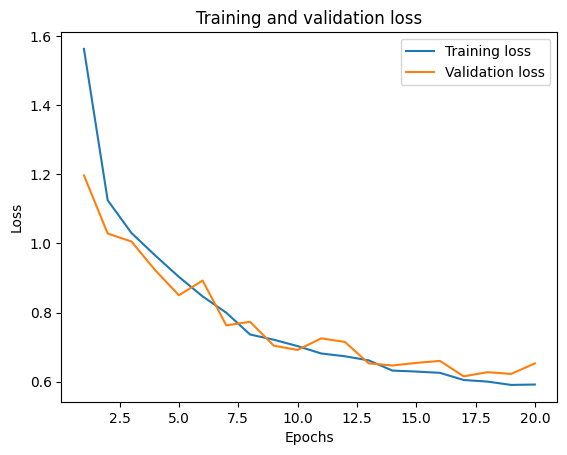

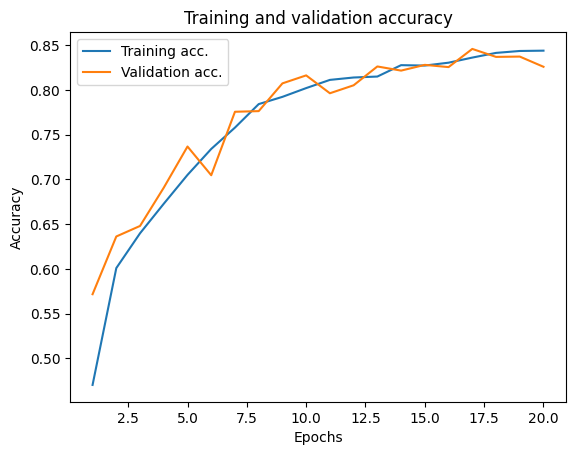

In [53]:
plot_loss_accuracy(history)

In [54]:
val_true = val_data_pred.labels
val_pred = model.predict(val_data_pred, verbose=0)

test_true = test_data.labels
test_pred = model.predict(test_data, verbose=0)

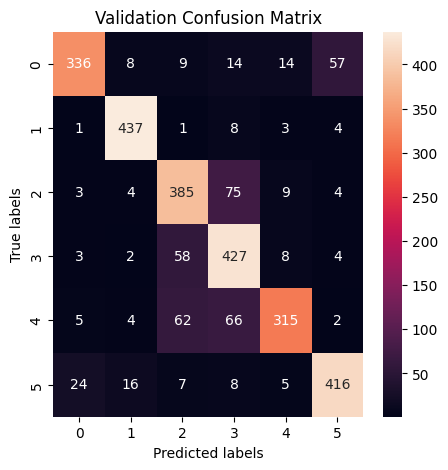

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       438
           1       0.93      0.96      0.94       454
           2       0.74      0.80      0.77       480
           3       0.71      0.85      0.78       502
           4       0.89      0.69      0.78       454
           5       0.85      0.87      0.86       476

    accuracy                           0.83      2804
   macro avg       0.84      0.83      0.83      2804
weighted avg       0.83      0.83      0.83      2804



In [55]:
confusion_matrix_and_classreport(val_data_pred.labels, val_pred, "Validation")

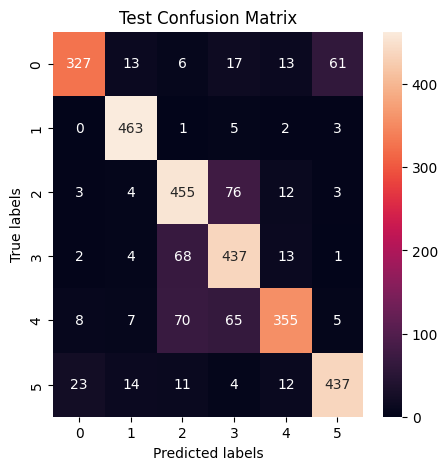

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       437
           1       0.92      0.98      0.95       474
           2       0.74      0.82      0.78       553
           3       0.72      0.83      0.77       525
           4       0.87      0.70      0.77       510
           5       0.86      0.87      0.86       501

    accuracy                           0.82      3000
   macro avg       0.84      0.82      0.83      3000
weighted avg       0.83      0.82      0.82      3000



In [56]:
confusion_matrix_and_classreport(test_data.labels, test_pred, "Test")

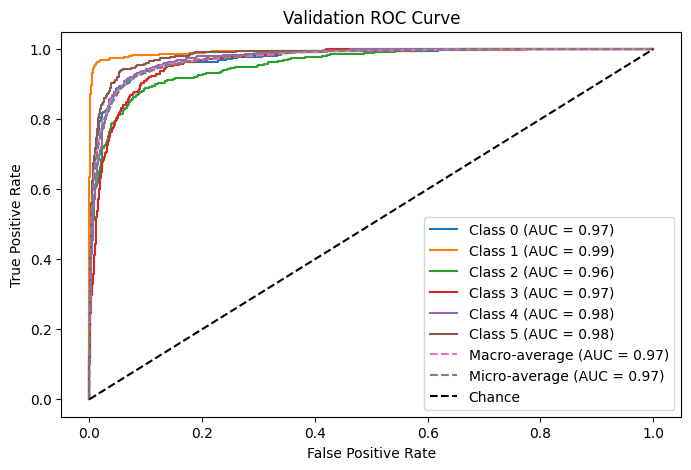

In [57]:
plot_roc_curve(val_data_pred.labels, val_pred, "Validation")

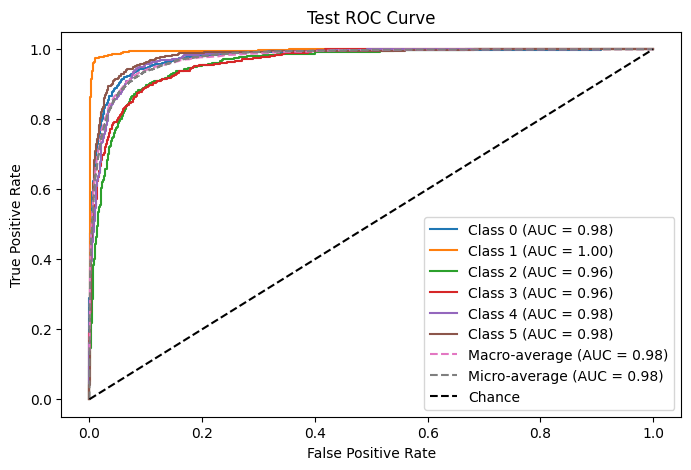

In [58]:
plot_roc_curve(test_data.labels, test_pred, "Test")

## Experimental model 5 -- Adding more dense layers

### Model New


In [59]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 256)      

In [61]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32)

Epoch 1/20
176/176 [==============================] - 40s 209ms/step - loss: 1.6305 - categorical_accuracy: 0.4463 - val_loss: 1.2940 - val_categorical_accuracy: 0.5489
Epoch 2/20
176/176 [==============================] - 37s 209ms/step - loss: 1.1609 - categorical_accuracy: 0.5909 - val_loss: 1.1218 - val_categorical_accuracy: 0.6056
Epoch 3/20
176/176 [==============================] - 36s 207ms/step - loss: 1.0794 - categorical_accuracy: 0.6232 - val_loss: 1.1776 - val_categorical_accuracy: 0.5813
Epoch 4/20
176/176 [==============================] - 36s 207ms/step - loss: 1.0166 - categorical_accuracy: 0.6423 - val_loss: 0.9850 - val_categorical_accuracy: 0.6651
Epoch 5/20
176/176 [==============================] - 37s 210ms/step - loss: 0.9800 - categorical_accuracy: 0.6644 - val_loss: 1.1298 - val_categorical_accuracy: 0.5959
Epoch 6/20
176/176 [==============================] - 36s 207ms/step - loss: 0.9577 - categorical_accuracy: 0.6789 - val_loss: 0.9593 - val_categorical_acc

### Evaluating

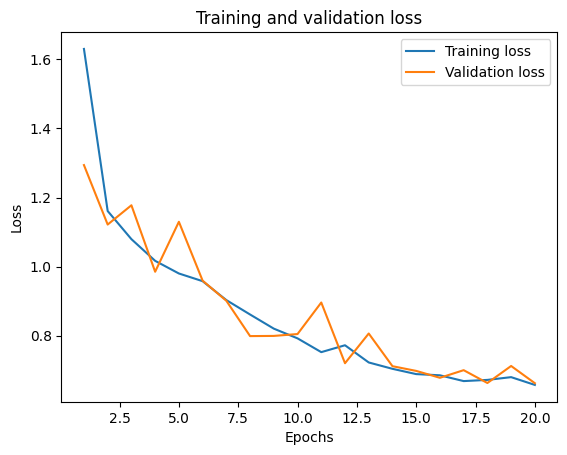

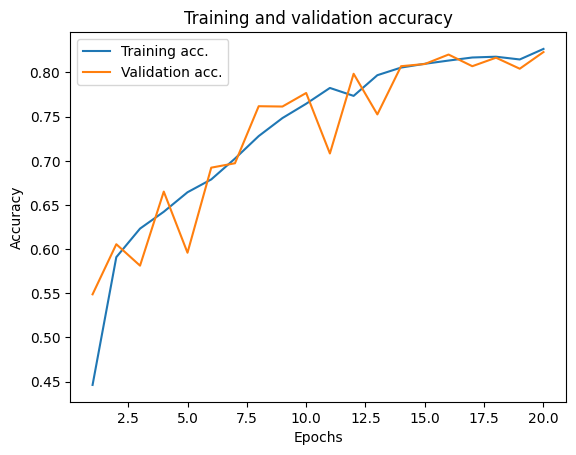

In [62]:
plot_loss_accuracy(history)

In [63]:
val_true = val_data_pred.labels
val_pred = model.predict(val_data_pred, verbose=0)

test_true = test_data.labels
test_pred = model.predict(test_data, verbose=0)

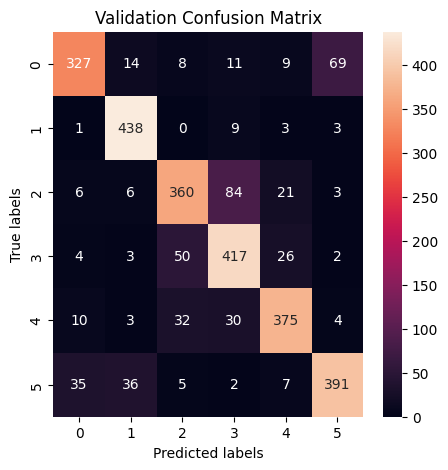

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       438
           1       0.88      0.96      0.92       454
           2       0.79      0.75      0.77       480
           3       0.75      0.83      0.79       502
           4       0.85      0.83      0.84       454
           5       0.83      0.82      0.82       476

    accuracy                           0.82      2804
   macro avg       0.83      0.82      0.82      2804
weighted avg       0.82      0.82      0.82      2804



In [64]:
confusion_matrix_and_classreport(val_data_pred.labels, val_pred, "Validation")

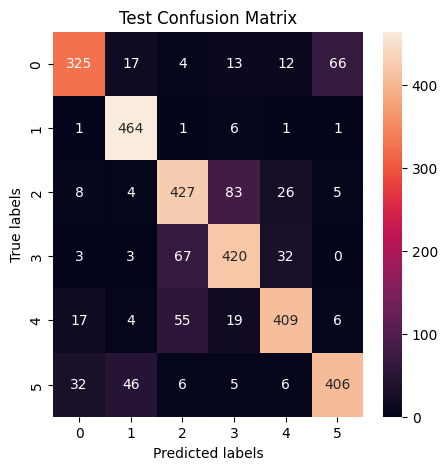

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       437
           1       0.86      0.98      0.92       474
           2       0.76      0.77      0.77       553
           3       0.77      0.80      0.78       525
           4       0.84      0.80      0.82       510
           5       0.84      0.81      0.82       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [65]:
confusion_matrix_and_classreport(test_data.labels, test_pred, "Test")

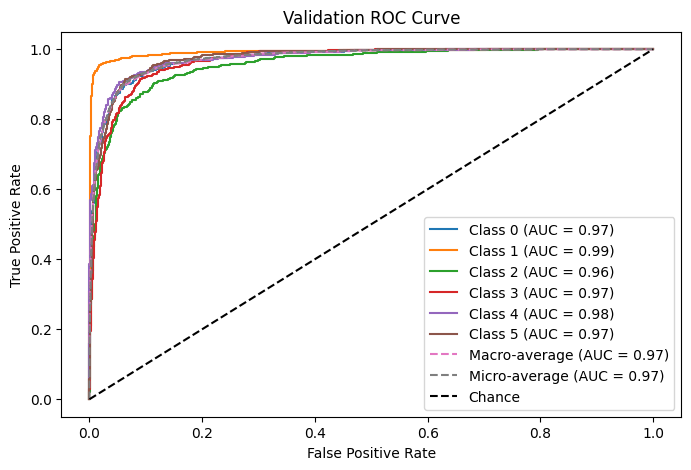

In [66]:
plot_roc_curve(val_data_pred.labels, val_pred, "Validation")

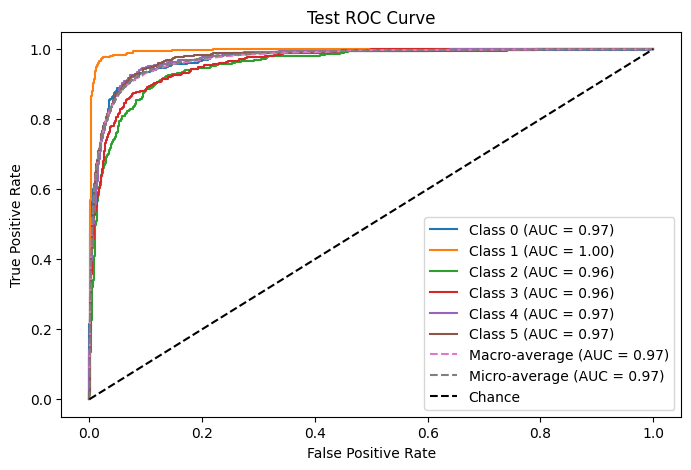

In [67]:
plot_roc_curve(test_data.labels, test_pred, "Test")

## Experimental model 6 -- Adding dense units

### Model New


In [68]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), padding ='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 256)      

In [71]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32)

Epoch 1/20
176/176 [==============================] - 37s 209ms/step - loss: 1.0079 - categorical_accuracy: 0.6709 - val_loss: 0.9226 - val_categorical_accuracy: 0.7015
Epoch 2/20
176/176 [==============================] - 36s 203ms/step - loss: 0.9086 - categorical_accuracy: 0.7147 - val_loss: 0.8258 - val_categorical_accuracy: 0.7546
Epoch 3/20
176/176 [==============================] - 37s 208ms/step - loss: 0.8635 - categorical_accuracy: 0.7378 - val_loss: 0.7724 - val_categorical_accuracy: 0.7760
Epoch 4/20
176/176 [==============================] - 36s 205ms/step - loss: 0.7769 - categorical_accuracy: 0.7708 - val_loss: 0.8097 - val_categorical_accuracy: 0.7778
Epoch 5/20
176/176 [==============================] - 36s 207ms/step - loss: 0.7480 - categorical_accuracy: 0.7850 - val_loss: 0.7537 - val_categorical_accuracy: 0.7942
Epoch 6/20
176/176 [==============================] - 36s 205ms/step - loss: 0.7202 - categorical_accuracy: 0.7971 - val_loss: 0.7381 - val_categorical_acc

### Evaluating

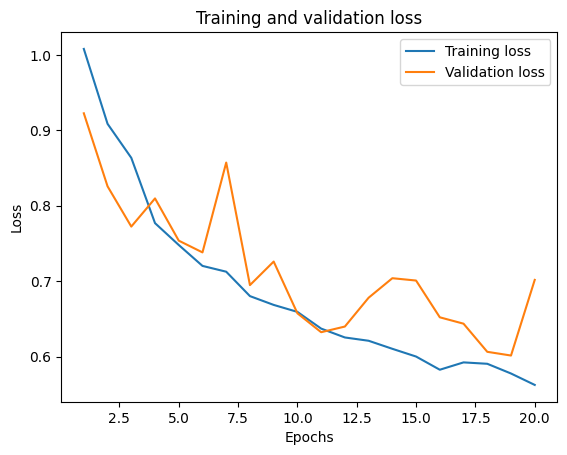

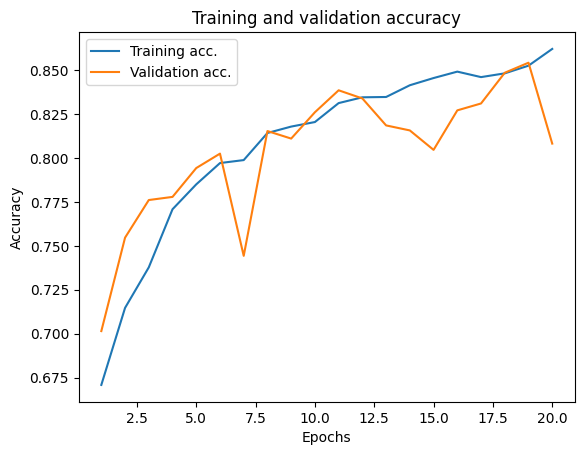

In [72]:
plot_loss_accuracy(history)

In [73]:
val_true = val_data_pred.labels
val_pred = model.predict(val_data_pred, verbose=0)

test_true = test_data.labels
test_pred = model.predict(test_data, verbose=0)

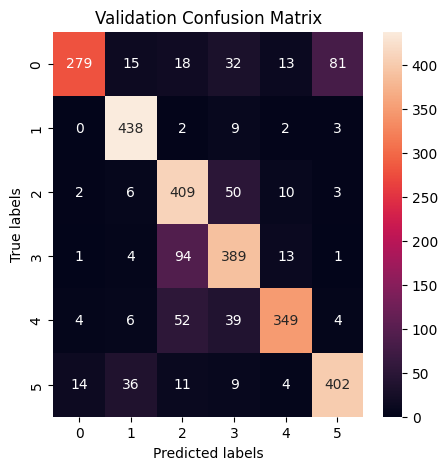

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.64      0.76       438
           1       0.87      0.96      0.91       454
           2       0.70      0.85      0.77       480
           3       0.74      0.77      0.76       502
           4       0.89      0.77      0.83       454
           5       0.81      0.84      0.83       476

    accuracy                           0.81      2804
   macro avg       0.82      0.81      0.81      2804
weighted avg       0.82      0.81      0.81      2804



In [74]:
confusion_matrix_and_classreport(val_data_pred.labels, val_pred, "Validation")

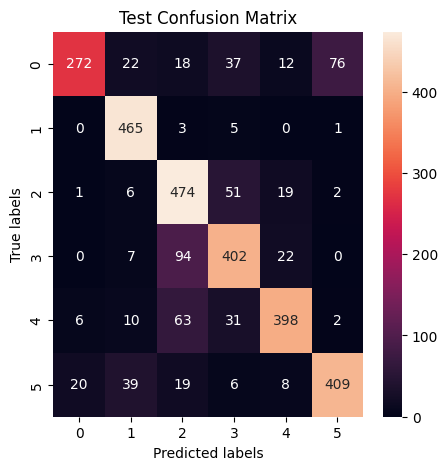

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.62      0.74       437
           1       0.85      0.98      0.91       474
           2       0.71      0.86      0.77       553
           3       0.76      0.77      0.76       525
           4       0.87      0.78      0.82       510
           5       0.83      0.82      0.83       501

    accuracy                           0.81      3000
   macro avg       0.82      0.80      0.81      3000
weighted avg       0.82      0.81      0.80      3000



In [75]:
confusion_matrix_and_classreport(test_data.labels, test_pred, "Test")

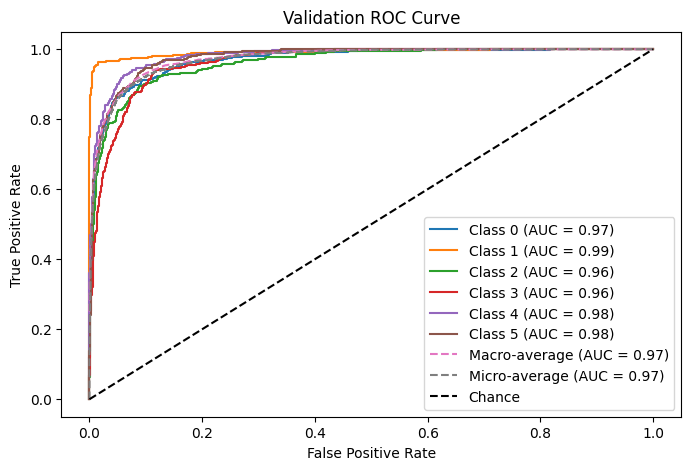

In [76]:
plot_roc_curve(val_data_pred.labels, val_pred, "Validation")

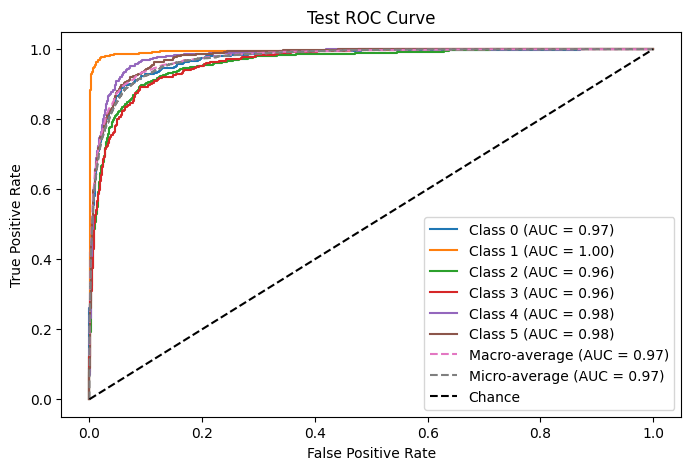

In [77]:
plot_roc_curve(test_data.labels, test_pred, "Test")

# Transfer Learning Model


In [78]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, input_shape = (64, 64, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

for layer in model.layers:
  layer.trainable = False

flat1 = layers.Flatten()(model.layers[-1].output)
dense1 = layers.Dense(64, activation = 'relu')(flat1)
dense2 = layers.Dense(32, activation = 'relu')(dense1)
output = layers.Dense(6, activation = 'softmax')(dense2)
model = Model(inputs = model.inputs, outputs = output)
model.summary()
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [80]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32)

Epoch 1/20
176/176 [==============================] - 40s 216ms/step - loss: 0.6881 - categorical_accuracy: 0.7425 - val_loss: 0.5429 - val_categorical_accuracy: 0.8056
Epoch 2/20
176/176 [==============================] - 37s 211ms/step - loss: 0.4700 - categorical_accuracy: 0.8272 - val_loss: 0.5179 - val_categorical_accuracy: 0.8117
Epoch 3/20
176/176 [==============================] - 37s 208ms/step - loss: 0.4224 - categorical_accuracy: 0.8447 - val_loss: 0.5040 - val_categorical_accuracy: 0.8260
Epoch 4/20
176/176 [==============================] - 37s 212ms/step - loss: 0.3988 - categorical_accuracy: 0.8565 - val_loss: 0.5170 - val_categorical_accuracy: 0.8224
Epoch 5/20
176/176 [==============================] - 37s 211ms/step - loss: 0.3591 - categorical_accuracy: 0.8715 - val_loss: 0.4777 - val_categorical_accuracy: 0.8392
Epoch 6/20
176/176 [==============================] - 37s 208ms/step - loss: 0.3390 - categorical_accuracy: 0.8784 - val_loss: 0.4948 - val_categorical_acc

### Evaluating

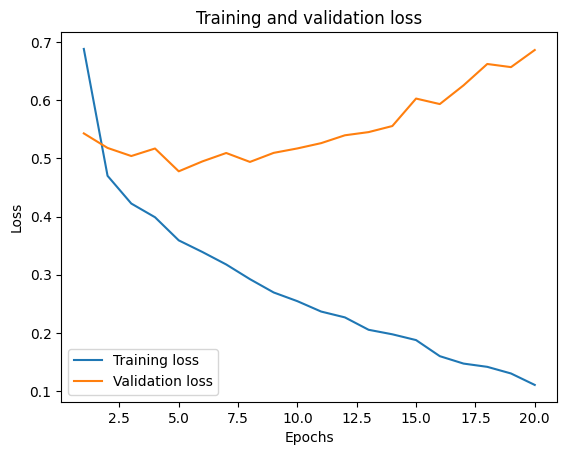

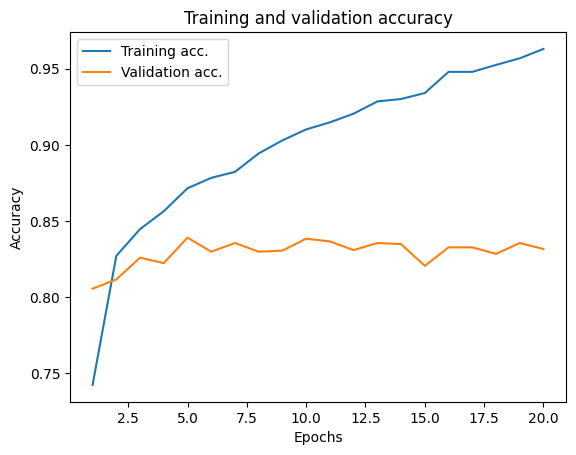

In [81]:
plot_loss_accuracy(history)

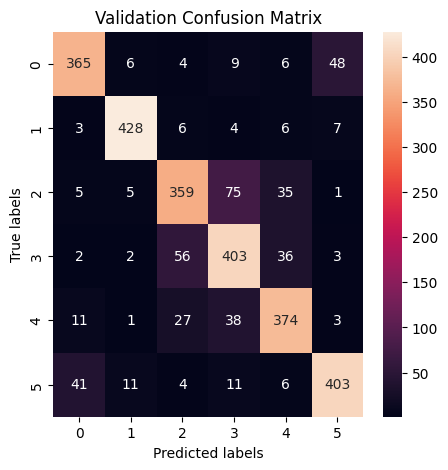

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       438
           1       0.94      0.94      0.94       454
           2       0.79      0.75      0.77       480
           3       0.75      0.80      0.77       502
           4       0.81      0.82      0.82       454
           5       0.87      0.85      0.86       476

    accuracy                           0.83      2804
   macro avg       0.83      0.83      0.83      2804
weighted avg       0.83      0.83      0.83      2804



In [82]:
confusion_matrix_and_classreport(val_data_pred.labels, model.predict(val_data_pred, verbose=0), "Validation")

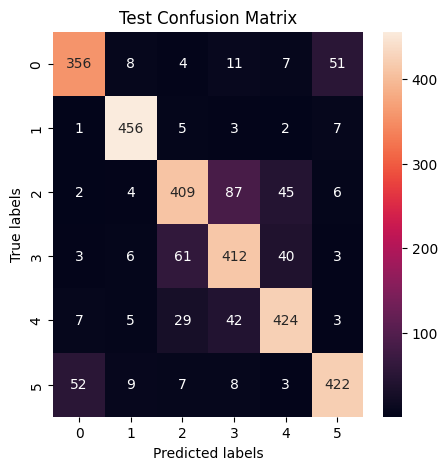

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       437
           1       0.93      0.96      0.95       474
           2       0.79      0.74      0.77       553
           3       0.73      0.78      0.76       525
           4       0.81      0.83      0.82       510
           5       0.86      0.84      0.85       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [83]:
confusion_matrix_and_classreport(test_data.labels,  model.predict(test_data, verbose=0), "Test")

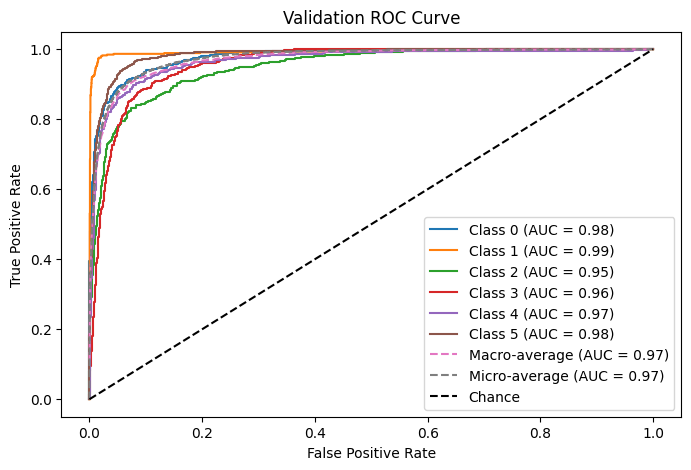

In [84]:
plot_roc_curve(val_data_pred.labels, model.predict(val_data_pred, verbose=0), "Validation")

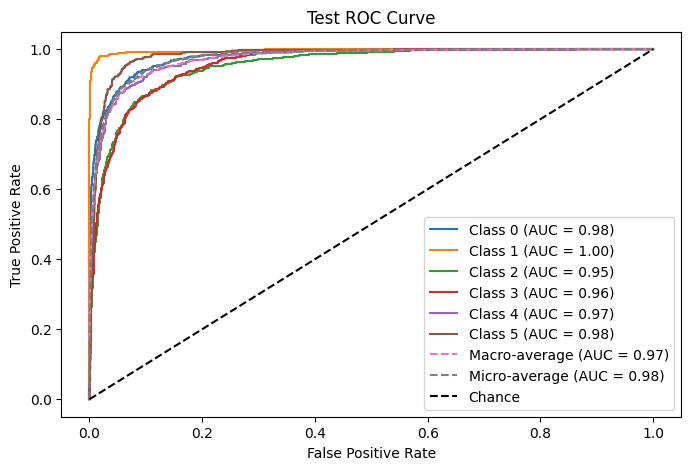

In [85]:
plot_roc_curve(test_data.labels,  model.predict(test_data, verbose=0), "Test")